# Health claim amounts and the GB family of distributions

Calculate and report the mean, median, maximum, minimum,
and standard deviation of monthly health expenditures for these data.
Plot two histograms of the data in which the y-axis gives the percent
of observations in the particular bin of health expenditures and the x-axis
gives the value of monthly health expenditures. Use percentage histograms
in which the height of each bar is the percent of observations in that bin

In the first histogram, use 1,000 bins to plot the frequency of all the data.
In the second histogram, use 100 bins to plot the frequency of only monthly
health expenditures less-than-or-equal-to \$800 ($x_i \leq 800$). Adjust the
frequencies of this second histogram to account for the observations that
you have not displayed ($x_i > 800$). That is, the heights of the histogram
bars in the second histogram should not sum to 1 because you are only
displaying a fraction of the data. Comparing the two histograms, why
might you prefer the second one?

In [8]:
# Load Modules
import numpy as np
import scipy.stats as sts
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spc
import scipy.integrate as integrate
import distributions as dst

In [9]:
# Import Data as Pandas Series
clms = pd.Series(np.loadtxt('clms.txt'))

In [10]:
# Obtain Summary Statistics
clms.describe()

count     10619.000000
mean        720.277975
std        3972.850824
min           0.010000
25%          74.450000
50%         172.210000
75%         451.535000
max      227967.250000
dtype: float64

<IPython.core.display.Javascript object>


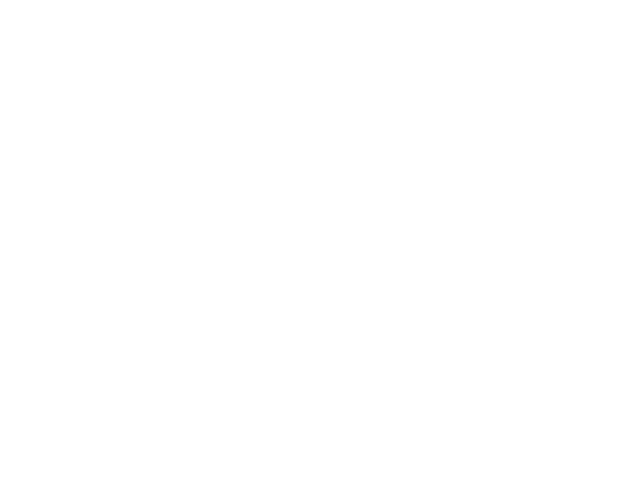

In [11]:
# Create first Histogram
# This command is specifically for Jupyter Notebook
%matplotlib notebook 
count, bins, ignored = plt.hist(clms, 1000, normed=True)
plt.title('Health Claims of Fictitious Households', fontsize=20)
plt.xlabel('US Dollars')
plt.ylabel('Percent of scores')
#plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"


<IPython.core.display.Javascript object>


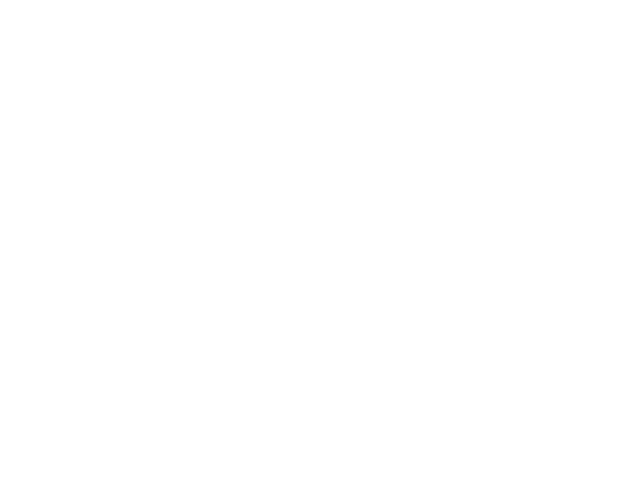

Histogram Bins sum to:  0.849420849421


In [12]:
# Create second Histogram
# This command is specifically for Jupyter Notebook
%matplotlib notebook 
weights = (1 / clms.shape[0]) * np.ones_like(clms)
count, bins, ignored = plt.hist(clms, bins=100, normed=False, weights=weights, range=(0,800))
#count, bins, ignored = plt.hist(clms, bins=100, normed=False, range=(0,800))
plt.title('Health Claims of Fictitious Households', fontsize=20)
plt.xlabel('US Dollars')
plt.ylabel('Percent of scores')

print('Histogram Bins sum to: ',count.sum())

In [13]:
weights

array([  9.41708259e-05,   9.41708259e-05,   9.41708259e-05, ...,
         9.41708259e-05,   9.41708259e-05,   9.41708259e-05])

## Gamma Distribution

In [14]:
# Define log likelihood function for the gamma distribution
def log_lik_gam(xvals, alpha, beta):
    #pdf_vals = sts.gamma.pdf(xvals, alpha, loc=0, scale=beta)
    pdf_vals = dst.gamma_pdf(xvals,alpha,beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [15]:
beta_0 = clms.var()/clms.mean()
alpha_0 = clms.mean()/beta_0
alpha_0, beta_0

(0.032869701035793335, 21913.12828014157)

In [16]:
print('Log-likelihood at Initial: ', log_lik_gam(clms, alpha_0, beta_0))

Log-likelihood at Initial:  -93556.2543421564


In [17]:
# Define Objective Function
def crit_gam(params, xvals):

    alpha, beta = params
    log_lik_val = log_lik_gam(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [18]:
# Check that objective function is working
crit_gam((alpha_0,beta_0),clms)

93556.2543421564

In [64]:
# Run Maximum Likelihood with Gamma
params_init = np.array([alpha_0, beta_0/3])
mle_args = (clms)
results1 = opt.minimize(crit_gam, params_init, args=(mle_args), bounds = ((0, None), (0, None)))
alpha_MLE1, beta_MLE1 = results1.x
print('alpha_MLE=', alpha_MLE1, ' beta_MLE=', beta_MLE1)

alpha_MLE= 0.286668433114  beta_MLE= 7304.37608027


In [65]:
results1

      fun: 79839.45445003443
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01455192,  0.27357601])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([  2.86668433e-01,   7.30437608e+03])

In [21]:
# Get Variance Covariance Matrix
vcv_mle1 = results1.hess_inv.todense()
stderr_mu_mle = np.sqrt(vcv_mle1[0,0])
stderr_sig_mle = np.sqrt(vcv_mle1[1,1])
print('VCV(MLE) = ', vcv_mle1)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  4.39738054e-06   1.40396108e-04]
 [  1.40396108e-04   1.00000101e+00]]
Standard error for mu estimate =  0.00209699321408
Standard error for sigma estimate =  1.00000050596


<IPython.core.display.Javascript object>


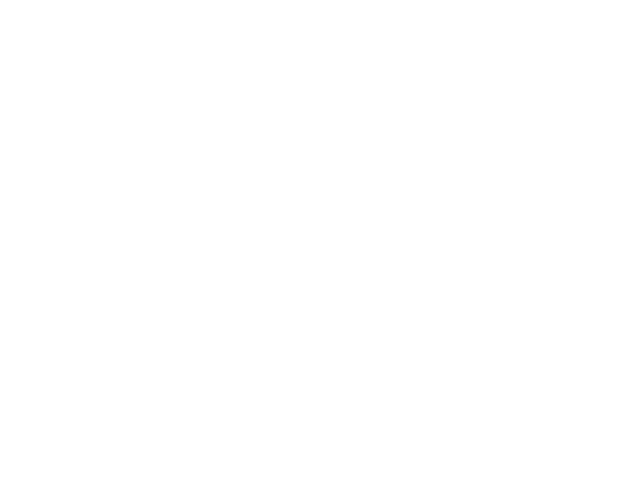

In [22]:
%matplotlib notebook 
weights = (1 / clms.shape[0]) * np.ones_like(clms)
count, bins, ignored = plt.hist(clms, bins=800, normed=False, weights=weights, range=(0,800))
plt.title('Health Claims of Fictitious Households', fontsize=20)
plt.xlabel('US Dollars')
plt.ylabel('Percent of scores')

# Plot the MLE estimated distribution
dist_pts = np.linspace(0, 800, 800)
plt.plot(dist_pts, sts.gamma.pdf(dist_pts, alpha_MLE1, loc=0, scale=beta_MLE1),
         linewidth=2, color='b', label='Gamma MLE Fit')
plt.legend(loc='upper right')

## Generalized Gamma Distribution

In [23]:
# Define log likelihood function for the generalized gamma distribution
def log_lik_ggam(xvals, alpha, beta, m):
    #pdf_vals = sts.gengamma.pdf(xvals, alpha, m, loc=0, scale=beta)
    pdf_vals = dst.ggamma_pdf(xvals,alpha,beta,m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [24]:
# Define Objective Function
def crit_ggam(params, xvals):

    alpha, beta, m = params
    log_lik_val = log_lik_ggam(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [66]:
# Run Maximum Likelihood with Generalized Gamma
m_0 = 1
params_init = np.array([alpha_MLE1, beta_MLE1/3, m_0])
mle_args = (clms)
results2 = opt.minimize(crit_ggam, params_init, args=(mle_args), bounds = ((0, None), (0, None), (0, None)))
alpha_MLE2, beta_MLE2, m_MLE2 = results2.x
print('alpha_MLE2=', alpha_MLE2, ' beta_MLE2=', beta_MLE2, 'm_MLE2=', m_MLE2)

alpha_MLE2= 0.391110489151  beta_MLE2= 2434.79191046 m_MLE2= 0.876869730403


In [67]:
results2

      fun: 77901.26515087273
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04511094,  0.64464984,  0.04947651])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 8
   status: 0
  success: True
        x: array([  3.91110489e-01,   2.43479191e+03,   8.76869730e-01])

In [27]:
# Get Variance Covariance Matrix
vcv_mle2 = results2.hess_inv.todense()
stderr_mu_mle = np.sqrt(vcv_mle2[0,0])
stderr_sig_mle = np.sqrt(vcv_mle2[1,1])
print('VCV(MLE) = ', vcv_mle2)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 0.0020606  -0.00219181 -0.02978938]
 [-0.00219181  1.00825401  0.03179456]
 [-0.02978938  0.03179456  0.43210589]]
Standard error for mu estimate =  0.0453938460659
Standard error for sigma estimate =  1.00411852459


<IPython.core.display.Javascript object>


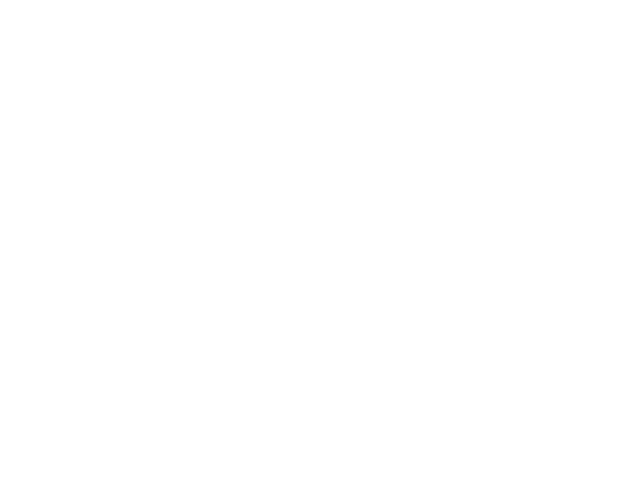

In [28]:
%matplotlib notebook 
weights = (1 / clms.shape[0]) * np.ones_like(clms)
count, bins, ignored = plt.hist(clms, bins=800, normed=False, weights=weights, range=(0,800))
plt.title('Health Claims of Fictitious Households', fontsize=20)
plt.xlabel('US Dollars')
plt.ylabel('Percent of scores')

# Plot the MLE estimated distribution
dist_pts = np.linspace(0, 800, 800)
plt.plot(dist_pts, sts.gengamma.pdf(dist_pts, alpha_MLE2, m_MLE2, loc=0, scale=beta_MLE2),
         linewidth=2, color='b', label='Generalized Gamma MLE Fit')
plt.legend(loc='upper right')

## Generalized Beta 2

In [29]:
# Define log likelihood function for the generalized beta distribution
def log_lik_gb2(xvals, a, b, p, q):
    pdf_vals = dst.gbeta2_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [30]:
# Check that syntax is correct by comparing GB2 to GGAM
# If syntax is correct, these two log likelihoods should be the same as q_0 -> infinity
# Also define initial conditions for log likelihood lower
print('ggam result', log_lik_ggam(clms, alpha_MLE2, beta_MLE2, m_MLE2))

q_0 = 100000
a_0, b_0, p_0 = m_MLE2, q_0**(1/m_MLE2)*beta_MLE2, alpha_MLE2/m_MLE2
print('gb2 result', log_lik_gb2(clms, a_0, b_0, p_0, q_0))

ggam result -82076.63530702936
gb2 result -82076.64347486885


In [31]:
# Define Objective Function
def crit_gb2(params, *args):

    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_gb2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [32]:
# Run Maximum Likelihood with Generalized Beta 2
# Define initial parameters using relationship between GB2 and GG 
params_init = np.array([a_0, b_0, p_0, q_0])
mle_args = (clms)
results3 = opt.minimize(crit_gb2, params_init, args=(mle_args), bounds = ((0, None), (0, None), (0, None), (0, None)))
a_MLE3, b_MLE3, p_MLE3, q_MLE3 = results3.x
print('a_MLE3=', a_MLE3, ' b_MLE3=', b_MLE3, 'p_MLE3=', p_MLE3, 'q_MLE3=', q_MLE3)

a_MLE3= 0.842972841813  b_MLE3= 2251642829.15 p_MLE3= 0.363825669008 q_MLE3= 100000.001607


In [33]:
results3

      fun: 78294.423643256334
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.05308674e+04,   0.00000000e+00,  -6.53626630e+03,
         2.91038305e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 3
   status: 0
  success: True
        x: array([  8.42972842e-01,   2.25164283e+09,   3.63825669e-01,
         1.00000002e+05])

In [34]:
# Get Variance Covariance Matrix
vcv_mle3 = results3.hess_inv.todense()
stderr_mu_mle = np.sqrt(vcv_mle3[0,0])
stderr_sig_mle = np.sqrt(vcv_mle3[1,1])
print('VCV(MLE) = ', vcv_mle3)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 0.03885427  0.         -0.07539436 -0.19718903]
 [ 0.          1.          0.          0.        ]
 [-0.07539436  0.          0.14632599  0.38283566]
 [-0.19718903  0.          0.38283566  1.00388924]]
Standard error for mu estimate =  0.197114865669
Standard error for sigma estimate =  1.0


<IPython.core.display.Javascript object>


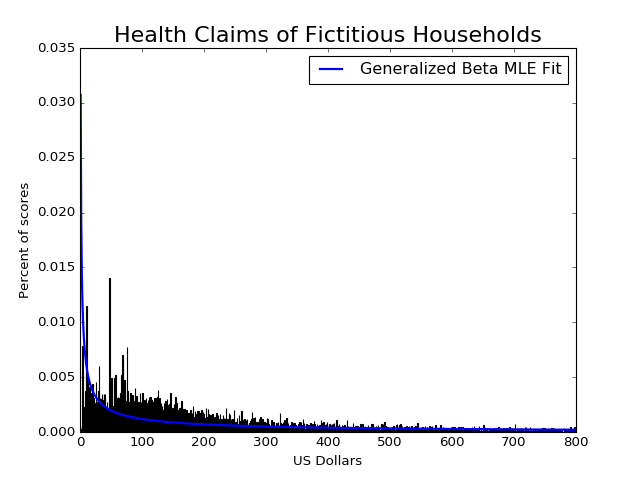

In [35]:
%matplotlib notebook 
weights = (1 / clms.shape[0]) * np.ones_like(clms)
count, bins, ignored = plt.hist(clms, bins=800, normed=False, weights=weights, range=(0,800))
plt.title('Health Claims of Fictitious Households', fontsize=20)
plt.xlabel('US Dollars')
plt.ylabel('Percent of scores')

# Plot the MLE estimated distribution
dist_pts = np.linspace(0, 800, 800)
plt.plot(dist_pts, dst.gbeta2_pdf(dist_pts, a_MLE3, b_MLE3, p_MLE3, q_MLE3),
         linewidth=2, color='b', label='Generalized Beta MLE Fit')
plt.legend(loc='upper right')

### Likelihood ratio test

Run two likelihood ratio tests, one for the Gamma distribution result, the other for the Generalized Gamma distribution result, both against the null hypothesis of the Generalized Beta distribution. The likelihood ratio test statistic is the following.

$$ LR(\tilde{\theta}|\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $$

This is a joint test of the likelihood of $H_0: \mu_0, \sigma_0$. The value of the $\chi^2(p)$ tells you the probability that the data could have been taken from the hypothesized distribution or model.

In [36]:
log_lik_gb2_mle = log_lik_gb2(clms, a_MLE3, b_MLE3, p_MLE3, q_MLE3)
log_lik_ggam_mle = log_lik_ggam(clms, alpha_MLE2, beta_MLE2, m_MLE2)
log_lik_gam_mle = log_lik_gam(clms, alpha_MLE1, beta_MLE1)

LR_val_gam_gb2 = 2 * (log_lik_gam_mle - log_lik_gb2_mle)
LR_val_ggam_gb2 = 2 * (log_lik_ggam_mle - log_lik_gb2_mle)

pval_gam_gb2 = 1.0 - sts.chi2.cdf(LR_val_gam_gb2, 4)
pval_ggam_gb2 = 1.0 - sts.chi2.cdf(LR_val_ggam_gb2, 4)

print('chi squared of H0: gam = gb2 with 4 degrees of freedom p-value = ', pval_gam_gb2)
print('chi squared of H0: ggam = gb2 with 4 degrees of freedom p-value= ', pval_ggam_gb2)

chi squared of H0: gam = gb2 with 4 degrees of freedom p-value =  1.0
chi squared of H0: ggam = gb2 with 4 degrees of freedom p-value=  1.0


### Calculating a Likelihood

Using the estimated GB2 distribution from part (d), how likely
am I to have a monthly health care claim of more than $1,000? How does
this amount change if I use the estimated GA distribution from part (b)?

In [37]:
# First, using the GB2 distribution
result = integrate.quad(lambda x: dst.gbeta2_pdf(x, a_MLE3, b_MLE3, p_MLE3, q_MLE3), 0, 1000)
gb2_1000 = 1 - result[0]
print('Likelihood of having a monthly healthcare claim of more than $1000 according to the Generalized Beta 2 Distribution: ',gb2_1000)

Likelihood of having a monthly healthcare claim of more than $1000 according to the Generalized Beta 2 Distribution:  0.2522878358098465


In [38]:
# Now using the GA distribution
gam_1000 = 1 - sts.gamma.cdf(1000, alpha_MLE1, loc=0, scale=beta_MLE2)
print('Likelihood of having a monthly healthcare claim of more than $1000 according to the Gamma Distribution: ',gam_1000)

Likelihood of having a monthly healthcare claim of more than $1000 according to the Gamma Distribution:  0.451963776279


## Ref: Generalized beta family of distributions
For exercises in this section, you will need to know the functional forms of four continuous univariate probability density functions (PDF's), each of which are part of the generalized beta family of distributions. The figure below is the generalized beta family of distributions [taken from McDonald and Xu (1995, Fig. 2)].

![title](GBtree.png)

The lognormal distribution (LN) is the distribution of the exponential of a normally distributed variable with mean $\mu$ and standard deviation $\sigma$. If the variable $x_i$ is lognormally distributed $x_i\sim LN(\mu,\sigma)$, then the log of $x_i$ is normally distributed $\ln(x_i)\sim N(\mu,\sigma)$. The PDF of the lognormal distribution is the following.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$

Note that the lognormal distribution has a support that is strictly positive. This is one reason why it is commonly used to approximate income distributions. A household's total income is rarely negative. The lognormal distribution also has a lot of the nice properties of the normal distribution.

Another two-parameter distribution with strictly positive support is the gamma (GA) distribution. The pdf of the gamma distribution is the following.

$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

The gamma function $\Gamma(\cdot)$ within the gamma (GA) distribution is a common function that has a preprogrammed function in most programming languages.

The lognormal (LN) and gamma (GA) distributions are both two-parameter distributions and are both special cases of the three-parameter generalized gamma (GG) distribution. The pdf of the generalized gamma distribution is the following.

$$ \text{(GG):}\quad f(x;\alpha,\beta,m) = \frac{m}{\beta^\alpha \Gamma\left(\frac{\alpha}{m}\right)}x^{\alpha-1}e^{-\left(\frac{x}{\beta}\right)^m},\quad x\in[0,\infty), \:\alpha,\beta,m>0 $$
$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

The relationship between the generalized gamma (GG) distribution and the gamma (GA) distribution is straightforward. The GA distribution equals the GG distribution at $m=1$.

$$ GA(\alpha,\beta) = GG(\alpha,\beta,m=1) $$

The relationship between the generalized gamma (GG) distribution and the lognormal (LN) distribution is less straightforward. The LN distribution equals the GG distribution as $\alpha$ goes to zero, $\beta = (\alpha\sigma)^{\frac{2}{\alpha}}$, and $m = \frac{\alpha\mu+1}{\alpha^2\sigma^2}$. See McDonald, et al (2013) for derivation.

$$ LN(\mu,\sigma) = \lim_{\alpha\rightarrow 0}GG\left(\alpha,\beta=(\alpha\sigma)^{\frac{2}{\alpha}},m=\frac{\alpha\mu+1}{\alpha^2\sigma^2}\right) $$

The last distribution we describe is the generalized beta 2 (GB2) distribution. Like the GG, GA, and LN distributions, it also has a strictly positive support. The PDF of the generalized beta 2 distribution is the following.

$$ \text{(GB2):}\quad f(x;a,b,p,q) = \frac{a x^{ap-1}}{b^{ap}B(p,q)\left(1 + \left(\frac{x}{b}\right)^a\right)^{p+q}},\quad x\in[0,\infty), \:a,b,p,q>0 $$
$$ \quad\text{where}\quad B(v,w)\equiv\int_0^1 t^{v-1}(1-t)^{w-1}dt $$

The beta function $B(\cdot,\cdot)$ within the GB2 distribution is a common function that has a preprogrammed function in most programming languages. The three-parameter generalized gamma (GG) distribution is a nested case of the four-parameter generalized beta 2 (GB2) distribution as $q$ goes to $\infty$ and for $a=m$, $b=q^{1/m}\beta$, and $p=\frac{\alpha}{m}$. See McDonald (1984, p. 662) for a derivation.

$$ GG(\alpha,\beta,m) = \lim_{q\rightarrow\infty}GB2\left(a=m,b=q^{1/m}\beta,p=\frac{\alpha}{m},q\right) $$

The statistical family tree figure above shows the all the relationships between the various PDF's in the generalized beta family of distributions.

## 7. References
* Brock, William A. and Leonard J. Mirman, "Optimal Economic Growth and Uncertainty: The Discounted Case," *Journal of Economic Theory*, 4:3, pp. 479-513 (June 1972).
* Davidson, Russell and James G. MacKinnon, *Econometric Theory and Methods*, Oxford University Press (2004).
* McDonald, James B., "Some Generalized Functions for the Size Distribution of Income," *Econometrica* 52:3, pp. 647-665 (May 1984).
* McDonald, James B. and Yexiao Xu, "A Generalization of the Beta Distribution with Applications," *Journal of Econometrics*, 66:1-2, pp. 133-152 (March-April 1995).
* McDonald, James B., Jeff Sorensen, and Patrick A. Turley, "Skewness and Kurtosis Properties of Income Distribution Models," *Review of Income and Wealth*, 59:2, pp. 360-374 (June 2013).